## Setup: import main modules

In [1]:
import rioxarray
#import warnings
#warnings.simplefilter("ignore", UserWarning)
import geopandas as gpd
import earthpy.plot as ep
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import math
import xarray as xr
import numpy as np

### Open files and read into memory

In [2]:
naip_data_train=rioxarray.open_rasterio("Ex2/Data/Train/naip.tif")
dem_data_train=rioxarray.open_rasterio("Ex2/Data/Train/dem.tif")
perfect_line=gpd.read_file("Ex2/Data/Train/refinedlines.shp")
#print(naip_data_train.rio.crs)
#print(perfect_line.crs)

### This function returns the data to get into the neural network

In [3]:
def nndata_reform(x_raster,y_raster,chunkResX,chunkResY,dims_x):
    '''
    Return two numpy arrays of formatted data
    '''
    #innefficient kinda
    #x_raster and y_raster need to have same extent, resolution, shape
    x_res, y_res = x_raster.rio.resolution()
    if x_res<0:
        x_res*=-1
    if y_res<0:
        y_res*=-1
    num_y = math.floor(x_raster.rio.height/chunkResY)
    num_x = math.floor(x_raster.rio.width/chunkResX)
    print("height chunks: "+str(num_y)+" width chunks: "+str(num_x))
    numChunks = num_y*num_x
    widthVal=int(num_x)
    
    preshuffle=np.zeros((numChunks,chunkResX,chunkResY,dims_x+1))
    #print("size of Xarray is "+str(XArray_return.shape))
    for i in range(num_y):
        for j in range(num_x):
            minx=j*chunkResX*x_res+x_raster.rio.bounds()[0]
            miny=i*chunkResY*y_res+x_raster.rio.bounds()[1]
            maxx=(j*chunkResX+chunkResX)*x_res+x_raster.rio.bounds()[0]
            maxy=(i*chunkResY+chunkResY)*y_res+x_raster.rio.bounds()[1]
            tempStore   =x_raster.rio.clip_box(minx,miny,maxx,maxy).values
            tempStore_y =y_raster.rio.clip_box(minx,miny,maxx,maxy).values
            for k in range(dims_x):
                for yfo in range(chunkResY):
                    for xfo in range(chunkResX):
                        preshuffle[i*widthVal+j][yfo][xfo][k]=tempStore[k][yfo][xfo]
                        if k==0:
                            preshuffle[i*widthVal+j][yfo][xfo][dims_x]=tempStore_y[yfo][xfo]  
    #need to add scrambler honestly because unet may or may not scramble the training so it might be weird
    np.random.shuffle(preshuffle)
    XArray_return,YArray_return=np.split(preshuffle,[5],3)
    print(XArray_return.shape)
    print(YArray_return.shape)
    return XArray_return,YArray_return

In [4]:
#concatenate data
merged_train=xr.concat([naip_data_train,dem_data_train] , "band")

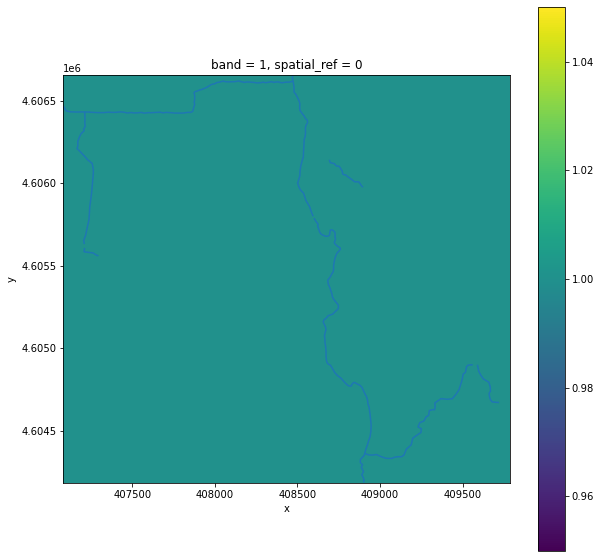

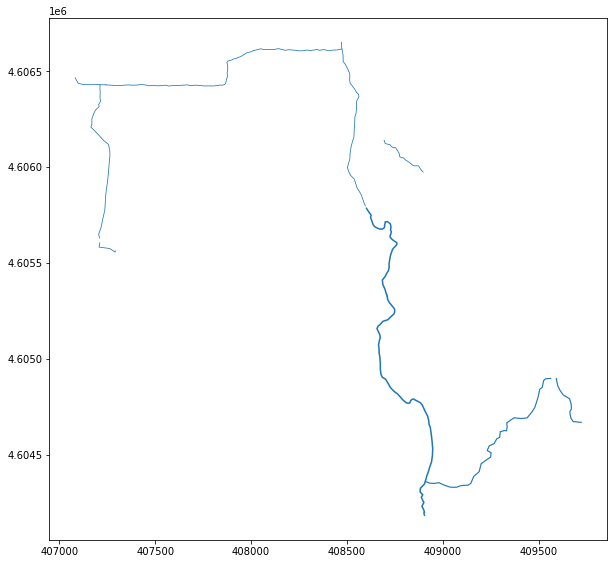

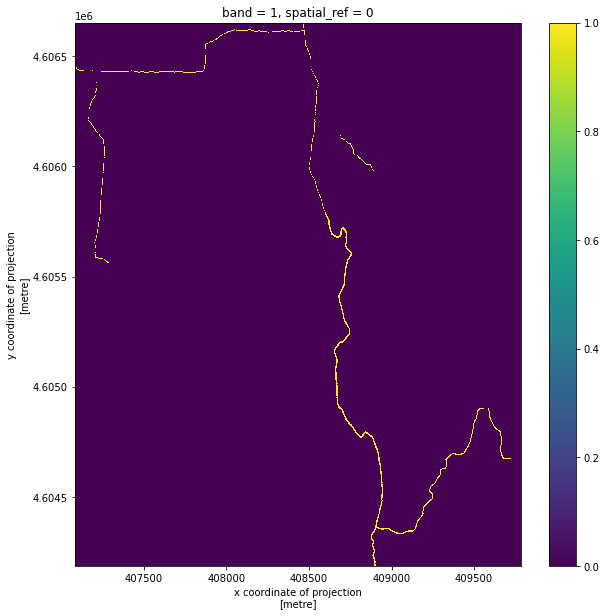

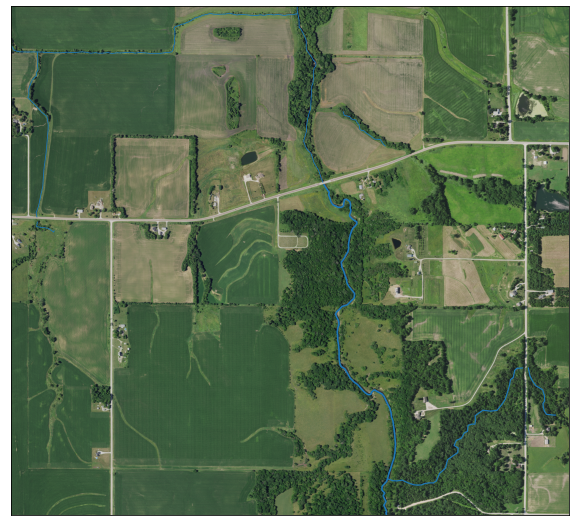

<xarray.DataArray ()>
array(39367.)
Coordinates:
    band         int32 1
    spatial_ref  int32 0


In [5]:
#print(perfect_line.to_crs('PROJCS["UTM_Zone_15_Northern_Hemisphere",GEOGCS["GCS_GRS_1980_IUGG_1980",DATUM["D_unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'))

#reproject line to the CRS of the raster image because raster image is more divisible by 224
#should test if there is a difference in reprojection innacuracy?
perfect_line=perfect_line.to_crs('PROJCS["UTM_Zone_15_Northern_Hemisphere",GEOGCS["GCS_GRS_1980_IUGG_1980",DATUM["D_unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

#create 1D grid of 1s to clip streamline out of, to create Y
naip_data_step1=(naip_data_train+1)/(naip_data_train+1)
naip_data_step2=naip_data_step1[0]
naip_data_step2.rio.set_nodata(0)
#print(naip_data_step2)


#show streamline on top of 1d grid
f, ax = plt.subplots()
 
naip_data_step2.plot(ax=ax)
perfect_line.plot(ax=ax)
plt.show()
other_river=gpd.GeoDataFrame({'geometry' : [perfect_line.at[0,'geometry'],perfect_line.at[1,'geometry'],perfect_line.at[7,'geometry'],perfect_line.at[8,'geometry'],perfect_line.at[9,'geometry'],perfect_line.at[10,'geometry'],perfect_line.at[11,'geometry'],perfect_line.at[12,'geometry']]}).set_crs('PROJCS["UTM_Zone_15_Northern_Hemisphere",GEOGCS["GCS_GRS_1980_IUGG_1980",DATUM["D_unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]').buffer(2)
forest_river=gpd.GeoDataFrame({'geometry' : [perfect_line.at[2,'geometry'],perfect_line.at[3,'geometry'],perfect_line.at[4,'geometry']]}).set_crs('PROJCS["UTM_Zone_15_Northern_Hemisphere",GEOGCS["GCS_GRS_1980_IUGG_1980",DATUM["D_unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]').buffer(4)
test3_river=gpd.GeoDataFrame({'geometry': [perfect_line.at[5,'geometry'],perfect_line.at[6,'geometry']]}).set_crs('PROJCS["UTM_Zone_15_Northern_Hemisphere",GEOGCS["GCS_GRS_1980_IUGG_1980",DATUM["D_unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]').buffer(3)
hypo_buffer=forest_river.append(other_river).append(test3_river)
hypo_buffer.plot()
plt.show()

#create raster data and show
#if river was much more different in width at different points, would have to split line
#into different sections and buffer from there before combining into GeoDataFrame/GeoSeries
line_raster=naip_data_step2.rio.clip(geometries=hypo_buffer,drop=False)
line_raster.plot()
#print(line_raster)
plt.show()

#plot image with raster line above it
f, ax = plt.subplots()
testExtent=merged_train.rio.bounds()
testExtent3=(testExtent[0],testExtent[2],testExtent[1],testExtent[3])
ep.plot_rgb(merged_train.values,ax=ax,extent=testExtent3)
hypo_buffer.plot(ax=ax)
plt.show()

#print number of data points that are river
print(np.sum(line_raster))

In [9]:
other_river=gpd.GeoDataFrame({'geometry' : [perfect_line.at[0,'geometry'],perfect_line.at[1,'geometry'],perfect_line.at[7,'geometry'],perfect_line.at[8,'geometry'],perfect_line.at[9,'geometry'],perfect_line.at[10,'geometry'],perfect_line.at[11,'geometry'],perfect_line.at[12,'geometry']]}).set_crs('PROJCS["UTM_Zone_15_Northern_Hemisphere",GEOGCS["GCS_GRS_1980_IUGG_1980",DATUM["D_unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]').buffer(3.2)
forest_river=gpd.GeoDataFrame({'geometry' : [perfect_line.at[2,'geometry'],perfect_line.at[3,'geometry'],perfect_line.at[4,'geometry']]}).set_crs('PROJCS["UTM_Zone_15_Northern_Hemisphere",GEOGCS["GCS_GRS_1980_IUGG_1980",DATUM["D_unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]').buffer(4)
test3_river=gpd.GeoDataFrame({'geometry': [perfect_line.at[5,'geometry'],perfect_line.at[6,'geometry']]}).set_crs('PROJCS["UTM_Zone_15_Northern_Hemisphere",GEOGCS["GCS_GRS_1980_IUGG_1980",DATUM["D_unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]').buffer(4)
hypo_buffer=forest_river.append(other_river).append(test3_river)
line_raster=naip_data_step2.rio.clip(geometries=hypo_buffer,drop=False)

In [7]:
print(np.sum(line_raster.values))

43116.0


In [10]:
# clip into 224x224 and export
# high processing time. can I copy 2d arrays into space for 2d array?
fourDArrayX,fourDArrayY = nndata_reform(merged_train,line_raster,224,224,5)

height chunks: 11 width chunks: 12
(132, 224, 224, 5)
(132, 224, 224, 1)


In [20]:
for i in range(0,fourDArrayY.shape[0]):
    print(str(i)+": "+str(np.sum(fourDArrayY[i])))

0: 0.0
1: 0.0
2: 0.0
3: 0.0
4: 0.0
5: 0.0
6: 0.0
7: 0.0
8: 3565.0
9: 969.0
10: 0.0
11: 0.0
12: 0.0
13: 0.0
14: 0.0
15: 0.0
16: 0.0
17: 0.0
18: 0.0
19: 0.0
20: 1821.0
21: 2456.0
22: 124.0
23: 0.0
24: 0.0
25: 0.0
26: 0.0
27: 0.0
28: 0.0
29: 0.0
30: 0.0
31: 1608.0
32: 1282.0
33: 0.0
34: 2691.0
35: 2100.0
36: 0.0
37: 0.0
38: 0.0
39: 0.0
40: 0.0
41: 0.0
42: 0.0
43: 1936.0
44: 0.0
45: 0.0
46: 449.0
47: 525.0
48: 0.0
49: 0.0
50: 0.0
51: 0.0
52: 0.0
53: 0.0
54: 0.0
55: 2272.0
56: 0.0
57: 0.0
58: 0.0
59: 0.0
60: 0.0
61: 0.0
62: 0.0
63: 0.0
64: 0.0
65: 0.0
66: 0.0
67: 1915.0
68: 0.0
69: 0.0
70: 0.0
71: 0.0
72: 996.0
73: 0.0
74: 0.0
75: 0.0
76: 0.0
77: 0.0
78: 603.0
79: 2511.0
80: 0.0
81: 0.0
82: 0.0
83: 0.0
84: 902.0
85: 0.0
86: 0.0
87: 0.0
88: 0.0
89: 0.0
90: 1159.0
91: 0.0
92: 21.0
93: 0.0
94: 0.0
95: 0.0
96: 1036.0
97: 0.0
98: 0.0
99: 0.0
100: 0.0
101: 0.0
102: 920.0
103: 1006.0
104: 136.0
105: 0.0
106: 0.0
107: 0.0
108: 992.0
109: 144.0
110: 224.0
111: 200.0
112: 0.0
113: 0.0
114: 962.0
115:

In [29]:
print(fourDArrayY.shape)
print("Size of X values (5d)"+str(fourDArrayX.size))
print("size of y values (1d)"+str(fourDArrayY.size))
# how many river pixels remain
print(np.sum(fourDArrayY))

(132, 224, 224, 1)
Size of X values (5d)33116160
size of y values (1d)6623232
33391.0


In [11]:
print(merged_train.shape)
print(line_raster.shape)

(5, 2467, 2704)
(2467, 2704)


In [11]:
# save numpy arrays to use in processing file
# 1 2 is 4
# 1.2 3 is 5
# 7 is 1 4 3
# 8 ios 7 shufflesd
# 10 is 2 4 3? 3 4 3?

fourDArrayY=fourDArrayY.astype('uint8')
fourDArrayX=fourDArrayX.astype('uint8')
np.save("Ex2/13Y_train224.npy", fourDArrayY)
np.save("Ex2/13X_train224.npy", fourDArrayX)

In [13]:
#weird capitalization difference
naip_data_test=rioxarray.open_rasterio("Ex2/Data/Test/testNAIP.tif")
dem_data_test=rioxarray.open_rasterio("Ex2/Data/Test/testDem.tif")
test_line=gpd.read_file("Ex2/Data/Test/testRefinedLines.shp")
#merge test data
merged_test=xr.concat([naip_data_test,dem_data_test] , "band")
print(merged_test)
#print(merged_test.rio.crs)
#reproject test_line to raster crs
test_line=test_line.to_crs('PROJCS["UTM_Zone_15_Northern_Hemisphere",GEOGCS["GCS_GRS_1980_IUGG_1980",DATUM["D_unknown",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

<xarray.DataArray (band: 5, y: 4513, x: 4172)>
array([[[ 90.        , 101.        ,  99.        , ..., 147.        ,
         139.        , 153.        ],
        [ 97.        ,  86.        ,  97.        , ..., 136.        ,
         134.        , 138.        ],
        [105.        ,  98.        , 103.        , ..., 100.        ,
         103.        , 111.        ],
        ...,
        [130.        , 117.        , 110.        , ..., 118.        ,
          95.        , 126.        ],
        [119.        , 109.        , 112.        , ..., 111.        ,
         100.        , 178.        ],
        [106.        , 111.        , 106.        , ..., 100.        ,
         107.        , 201.        ]],

       [[113.        , 124.        , 121.        , ..., 125.        ,
         128.        , 136.        ],
        [120.        , 116.        , 122.        , ..., 128.        ,
         127.        , 122.        ],
        [138.        , 126.        , 125.        , ..., 140.        ,
    

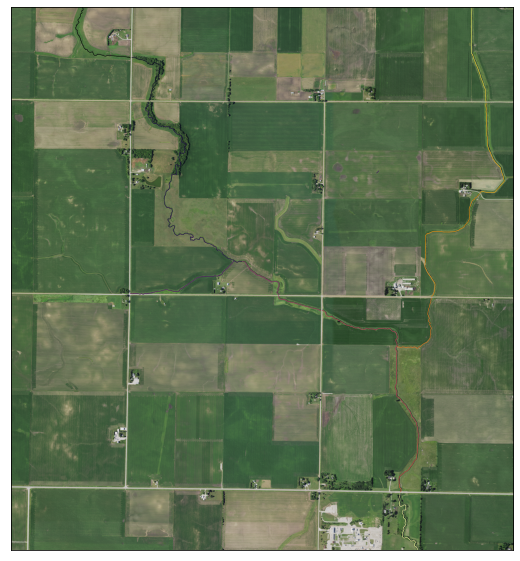

graphs are different sizes even though same extent because difference between ep.plot_rgb and xarray.plot


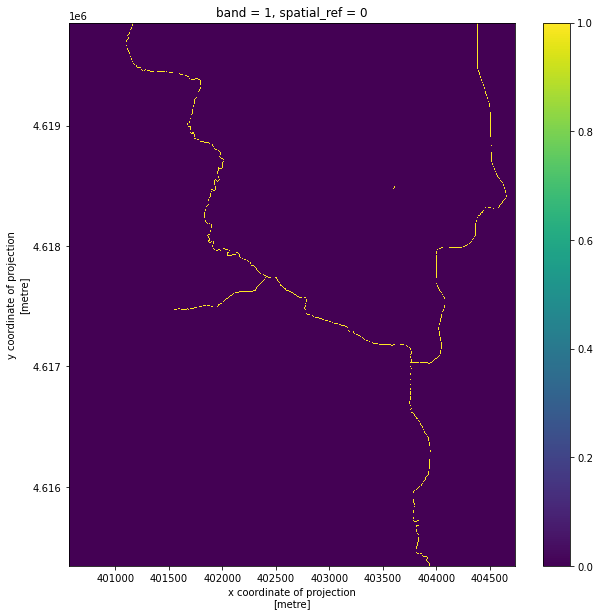

In [16]:
## plot test data just to show
f, ax = plt.subplots()
testExtent=merged_test.rio.bounds()
testExtentTest=(testExtent[0],testExtent[2],testExtent[1],testExtent[3])
ep.plot_rgb(merged_test.values,extent=testExtentTest,ax=ax)
test_line.buffer(2).plot(ax=ax,cmap='inferno')
plt.show()

#create 1D grid of 1s to clip streamline out of, to create Y
test_data_step1=(naip_data_test+1)/(naip_data_test+1)
test_data_step2=test_data_step1[0]
test_data_step2.rio.set_nodata(0)
#clip the data
test_raster=test_data_step2.rio.clip(geometries=test_line.buffer(3),drop=False)
test_raster.plot()
print("graphs are different sizes even though same extent because difference between ep.plot_rgb and xarray.plot")
plt.show()

In [17]:
fourDArrayX_test,fourDArrayY_test = nndata_reform(merged_test,test_raster,224,224,5)

height chunks: 20 width chunks: 18
(360, 224, 224, 5)
(360, 224, 224, 1)


In [90]:
print(np.sum(fourDArrayX_test))

13881847839.0766


In [18]:
fourDArrayY_test=fourDArrayY_test.astype('uint8')
fourDArrayX_test=fourDArrayX_test.astype('uint8')
np.save("Ex2/2Y_test224.npy", fourDArrayY_test)
np.save("Ex2/2X_test224cti.npy", fourDArrayX_test)

In [92]:
for i in range(0,fourDArrayY_test.shape[0]):
    print(str(i)+": "+str(np.sum(fourDArrayY_test[i])))

0: 0.0
1: 0.0
2: 0.0
3: 0.0
4: 0.0
5: 0.0
6: 0.0
7: 0.0
8: 0.0
9: 0.0
10: 0.0
11: 0.0
12: 0.0
13: 0.0
14: 1169.0
15: 171.0
16: 0.0
17: 0.0
18: 0.0
19: 0.0
20: 0.0
21: 0.0
22: 0.0
23: 0.0
24: 0.0
25: 0.0
26: 0.0
27: 0.0
28: 0.0
29: 0.0
30: 0.0
31: 0.0
32: 1287.0
33: 0.0
34: 0.0
35: 0.0
36: 0.0
37: 0.0
38: 0.0
39: 0.0
40: 0.0
41: 0.0
42: 0.0
43: 0.0
44: 0.0
45: 0.0
46: 0.0
47: 0.0
48: 0.0
49: 0.0
50: 1032.0
51: 0.0
52: 0.0
53: 0.0
54: 0.0
55: 0.0
56: 0.0
57: 0.0
58: 0.0
59: 0.0
60: 0.0
61: 0.0
62: 0.0
63: 0.0
64: 0.0
65: 0.0
66: 0.0
67: 0.0
68: 388.0
69: 597.0
70: 0.0
71: 0.0
72: 0.0
73: 0.0
74: 0.0
75: 0.0
76: 0.0
77: 0.0
78: 0.0
79: 0.0
80: 0.0
81: 0.0
82: 0.0
83: 0.0
84: 0.0
85: 0.0
86: 236.0
87: 722.0
88: 0.0
89: 0.0
90: 0.0
91: 0.0
92: 0.0
93: 0.0
94: 0.0
95: 0.0
96: 0.0
97: 0.0
98: 0.0
99: 0.0
100: 0.0
101: 0.0
102: 0.0
103: 0.0
104: 1098.0
105: 0.0
106: 0.0
107: 0.0
108: 0.0
109: 0.0
110: 0.0
111: 0.0
112: 0.0
113: 0.0
114: 0.0
115: 0.0
116: 0.0
117: 0.0
118: 0.0
119: 0.0
120: 0.0